In [1]:
%pylab inline
import Stracers as st
import sys
sys.path.append('../MW_anisotropy/code/')
sys.path.append('../MW_anisotropy/code/densities/')

import density_tools
import reading_snapshots
from pygadgetreader import *



/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:841: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/ngaravito/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


Populating the interactive namespace from numpy and matplotlib


In [2]:
def rho_enclosed(r_posh, rmin, rmax, nbins, mass):
    r = np.linspace(rmin, rmax, nbins-1)
    rho = np.zeros(nbins-1)

    # Loop over the radial bins.
    for i in range(1, len(r)):
        indexh = np.where((r_posh<r[i]) & (r_posh>r[i-1]))[0]

        rho[i-1] = (3*(np.sum(mass[indexh]))) / (4*np.pi*(r[i]**3-r[i-1]**3))

    return r, rho

In [3]:
def all_host_particles(xyz, vxyz, pids, pot, mass, N_host_particles):
    """
    Function that return the host and the sat particles
    positions and velocities.

    Parameters:
    -----------
    xyz: snapshot coordinates with shape (n,3)
    vxys: snapshot velocities with shape (n,3)
    pids: particles ids
    Nhost_particles: Number of host particles in the snapshot
    Returns:
    --------
    xyz_mw, vxyz_mw, xyzlmc, vxyz_lmc: coordinates and velocities of
    the host and the sat.

    """
    sort_indexes = np.sort(pids)
    N_cut = sort_indexes[N_host_particles]
    host_ids = np.where(pids<N_cut)[0]
    return xyz[host_ids], vxyz[host_ids], pids[host_ids], pot[host_ids], mass[host_ids]

In [4]:
def Stellar_properties(ids_weights, weights, ids, mass, pos, vel):
    assert len(ids_weights)<= len(ids), 'Error: length of weights ids is larger than lenght of ids!'
    
    common_ids = np.isin(ids, ids_weights)
    # selecting elements that are common in weight_ids and ids:
    ids_n = ids[common_ids]
    mass_n = mass[common_ids]
    pos_n = pos[common_ids]
    vel_n = vel[common_ids]
    print(len(ids), len(ids_n))
    assert len(ids_n) == len(ids_weights), 'Same number of particles'
    # Sorting ids:
    ids_w_arg_sort = np.argsort(ids_weights)
    ids_arg_sort = np.argsort(ids_n)
    print(len(ids_n), len(ids_weights))
    print(len(ids_w_arg_sort), len(ids_arg_sort))
    
    comp_items = ids_weights[ids_w_arg_sort]==ids_n[ids_arg_sort]
    false_ind = np.where(comp_items==False)[0]
    
    print(len(false_ind))
    
    assert (len(false_ind)==0), 'Error: Hey!'
    
    # Sorting ids and properties
    weights_n = weights[ids_w_arg_sort]
    ids_weights_n = ids_weights[ids_w_arg_sort]
    
    # Sorting future properties
    ids_n = ids_n[ids_arg_sort]
    mass_n = mass_n[ids_arg_sort]*weights_n
    posx = pos_n[ids_arg_sort,0]
    posy = pos_n[ids_arg_sort,1]
    posz = pos_n[ids_arg_sort,2]

    velx = vel_n[ids_arg_sort,0]*weights_n
    vely = vel_n[ids_arg_sort,1]*weights_n
    velz = vel_n[ids_arg_sort,2]*weights_n
    
    all_pos = np.array([posx, posy, posz]).T
    all_vel = np.array([velx, vely, velz]).T
        
    return [ids_weights_n, weights_n, ids_n], mass_n, all_pos, all_vel

In [16]:
def energies(snap, rcut=0, LMC=0):

    MW_pos = readsnap(snap, 'pos', 'dm')
    MW_vel = readsnap(snap, 'vel', 'dm')
    MW_mass = readsnap(snap, 'mass', 'dm')
    MW_pot = readsnap(snap, 'pot', 'dm')
    MW_ids = readsnap(snap, 'pid', 'dm')

    
    # Selecting MW particles
    if LMC==1:
        N_host_particles = 100000000
        MW_pos, MW_vel, MW_ids, MW_pot, MW_mass = all_host_particles(pp, vv, ids, Epp, massarr, N_host_particles)
        assert len(MW_ids)==N_host_particles, 'Error: something went wrong selecting the host particles'
    
    
    rr=np.sqrt(MW_pos[:,0]**2+MW_pos[:,1]**2+MW_pos[:,2]**2)
    
    
    if rcut>0:
        r_cut = np.where((rr<rcut))[0]

        rr = rr[r_cut]
        MW_pos = MW_pos[r_cut]
        MW_vel = MW_vel[r_cut]
        MW_mass = MW_mass[r_cut]
        MW_pot = MW_pot[r_cut]
        MW_ids = MW_ids[r_cut]

    v2=MW_vel[:,0]**2+MW_vel[:,1]**2+MW_vel[:,2]**2
    Ekk=0.5*v2
    
    return rr, Ekk, MW_pot, MW_ids, MW_mass, MW_pos, MW_vel


In [17]:
rr_init, Ekk_init, Epp_init, ids_init, massarr_init, mw_pos, mw_vel = energies('../MW_anisotropy/code/test_snaps/MW2_100M_beta0_vir_020'
                                                                              ,rcut=300)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Potential
Returning DM    Particle IDs


In [18]:
rr_fut, Ekk_fut, Epp_fut, ids_fut, massarr_fut, mw_pos_f, mw_vel_f = energies('../MW_anisotropy/code/test_snaps/MW2_100M_beta0_vir_040')

Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Potential
Returning DM    Particle IDs


In [ ]:
wh, w_ids_h = st.weight_triaxial(rr_init, Ekk_init, Epp_init, ids_init, massarr_init[3],
                                 0.01, 100, 1, 'Hernquist', [25])

In [10]:
# # stellar properties at the begining:
ST_init  = Stellar_properties(w_ids_h, wh, ids_init, massarr_init, mw_pos, mw_vel)

77660043 77660043
77660043 77660043
77660043 77660043
0


In [12]:
# stellar properties at the present time:
ST_fut  = Stellar_properties(w_ids_h, wh, ids_fut, massarr_fut, mw_pos_f, mw_vel_f)

NameError: name 'ids_fut' is not defined

In [11]:
all_i, mass_n_i, pos_i, vel_i = ST_init
all_f, mass_n_f, pos_f, vel_f = ST_fut

NameError: name 'ST_fut' is not defined

In [13]:
pos_i_w = np.array([posx_i, posy_i, posz_i]).T
pos_f_w = np.array([posx_f, posy_f, posz_f]).T

vel_i_w = np.array([velx_i, vely_i, velz_i]).T
vel_f_w = np.array([velx_f, vely_f, velz_f]).T

In [14]:
rho_mw_st_init = density_tools.density_nn(pos_i_w, 200, 100, 10, 1000, mass=mass_n_i)

In [15]:
rho_mw_st_fut = density_tools.density_nn(pos_f_w, 200, 100, 10, 1000, mass=mass_n_f)

In [ ]:
#rho_mw_dm = density_tools.density_nn(pp, 200, 100, 10, 1000, mass=massarr*1E10)

0

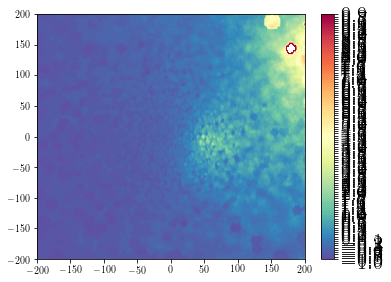

In [29]:
density_tools.density_peaks(rho_mw_st_fut/rho_mw_st_init - 1, xmin=-200, xmax=200, 
                            ymin=-200, ymax=200, fsize=(6, 4.5),  levels=np.arange(-1.0, 10, 0.1))

In [ ]:
density_tools.density_peaks(np.log(rho_mw_dm)/np.max(np.log(rho_mw_dm)), xmin=-100, xmax=100, 
                            ymin=-100, ymax=100, fsize=(6, 4.5),  levels=np.arange(0, 1.05, 0.1))